## Chaotic Lorenz System (non linear ODE)

In [ ]:
pip install pysindy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 17.7 MB/s 


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

import numpy as np

from scipy.integrate import solve_ivp
from scipy.io import loadmat

from pysindy.utils import lorenz
import pysindy as ps

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

The Lorenz system serves as an example of a nonlinear ODE whose solutions exhibit chaotic dynamics evolving on a strange attractor. The Lorenz system is given by

$$ \begin{aligned} \dot x &= \sigma(y-x)\\ \dot y &= x(\rho - z) - y \\ \dot z &= xy - \beta z, \end{aligned} $$
with $\sigma=10$, $\rho=28$, and $\beta=\tfrac{8}{3}$ for this example. We generate our training data starting from the initial condition $(-8, 8, 27)$. Note that for this example we also collect measurements of derivatives of state variables, $(\dot x, \dot y, \dot z)$.

In [ ]:
# generate training data

dt = 0.001
# generate timestamps from 0 to 100s separated by dt seconds
t_train = np.arange(0, 100, dt)
t_train_span = (t_train[0], t_train[-1])

# set the initial conditions
x0_train = [-8, 8, 27] 

# generate x, y, z by integrating over t
# parameters sigma, rho, and beta are set in the `lorenz` function
x_train = solve_ivp(lorenz, t_train_span, 
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

# generate x_dot, y_dot, z_dot
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)

In [ ]:
print("Total number of samples:",len(x_train))

Total number of samples: 100000


Training the model requires setting the following hyperparameters- 
1. Optimizer threshold - 

In [ ]:
# finding the best hyperparameters by performing cross validation

model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)

search.fit(x_train)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.001}
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [ ]:
# Fit the model with best hyperparameters

poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [ ]:
# Simulate and plot the results
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
plot_kws1 = dict(linewidth=1)

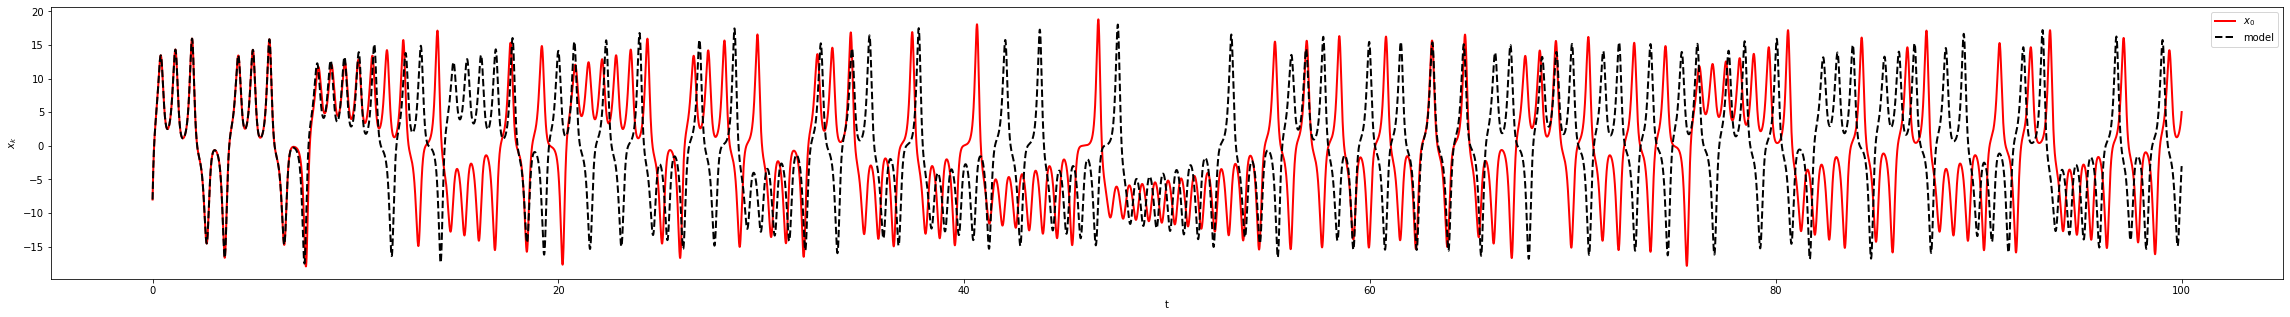

In [ ]:
fig = plt.figure(figsize=(40,5))
plt.plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
plt.plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

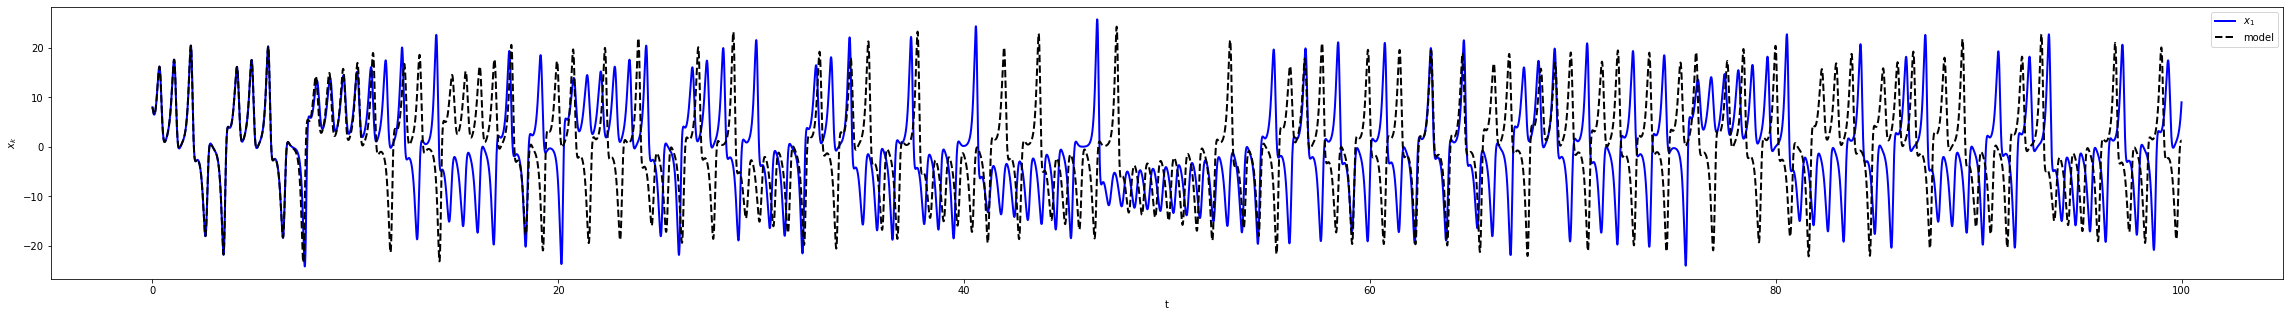

In [ ]:
fig = plt.figure(figsize=(40,5))
plt.plot(t_train, x_train[:, 1], "b", label="$x_1$", **plot_kws)
plt.plot(t_train, x_sim[:, 1], "k--", label="model", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

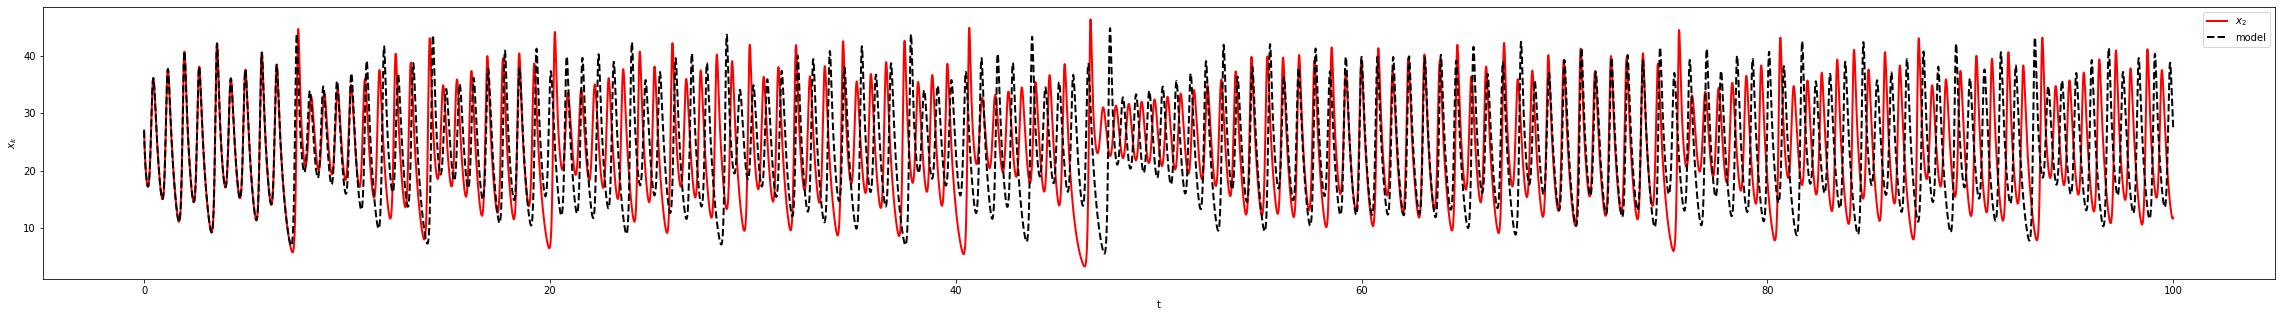

In [ ]:
fig = plt.figure(figsize=(40,5))
plt.plot(t_train, x_train[:, 2], "r", label="$x_2$", **plot_kws)
plt.plot(t_train, x_sim[:, 2], "k--", label="model", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

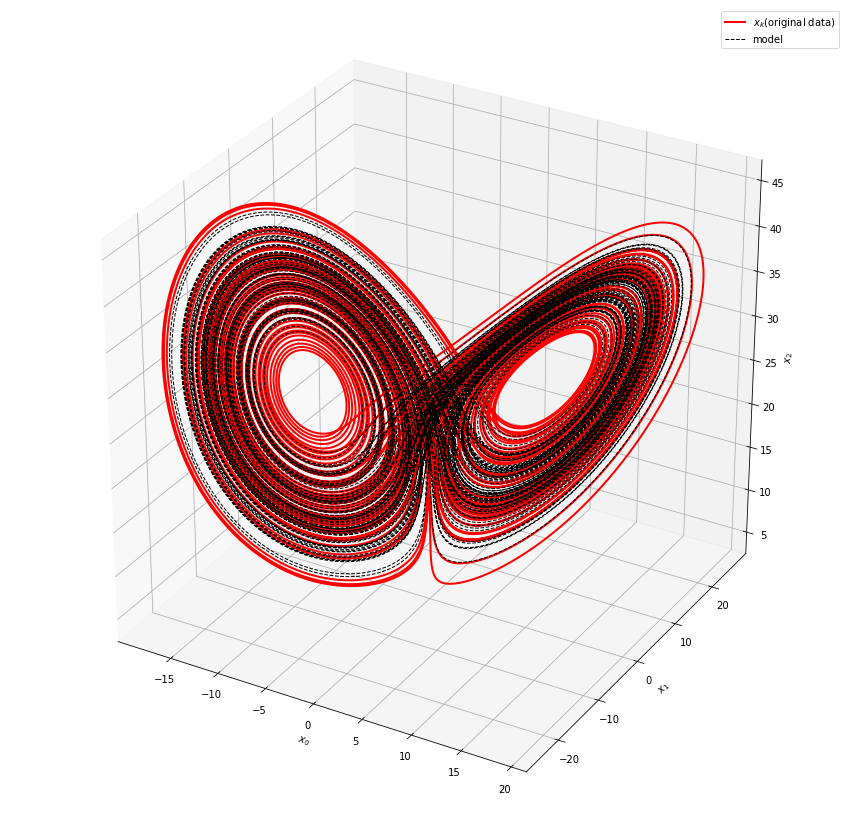

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$(original data)", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws1)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

"In the Lorenz example, the ability to capture dynamics on the
attractor is more important than the ability to predict an individual
trajectory, because chaos will quickly cause any small variations in
initial conditions or model coefficients to diverge exponentially." 

This statement captures the property of Lorez systems that the attractors characterize the system, rather than the trajectories. This is due to the fact that the Lorenz system is chaotic.

### Observations for varying levels of noise

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


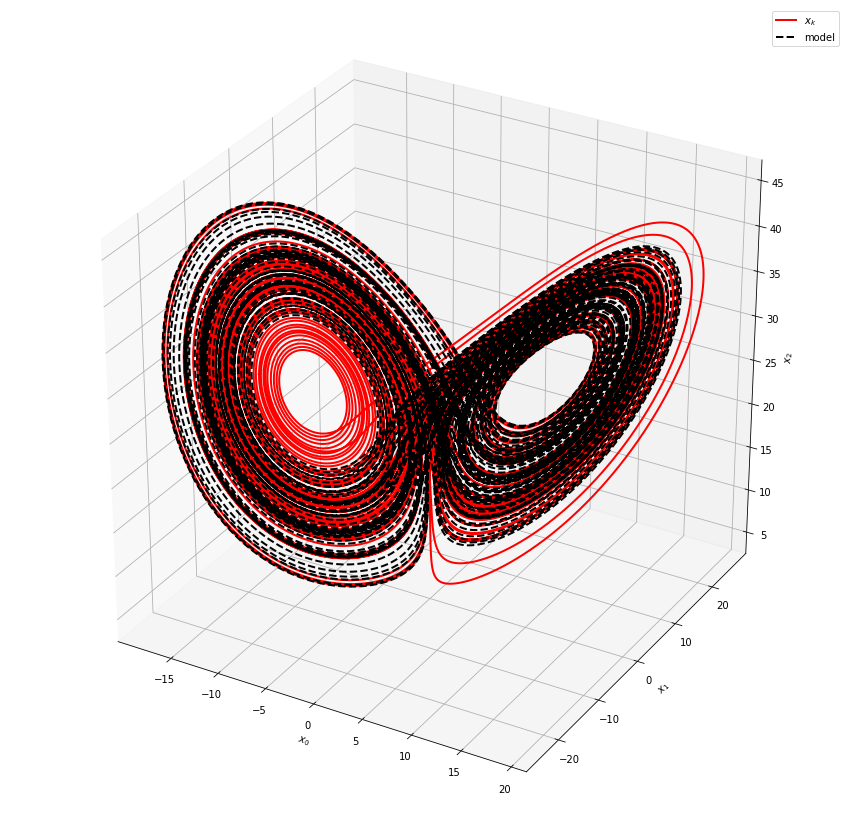

In [ ]:
#adding noise on a scale of 1e-4
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-4, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


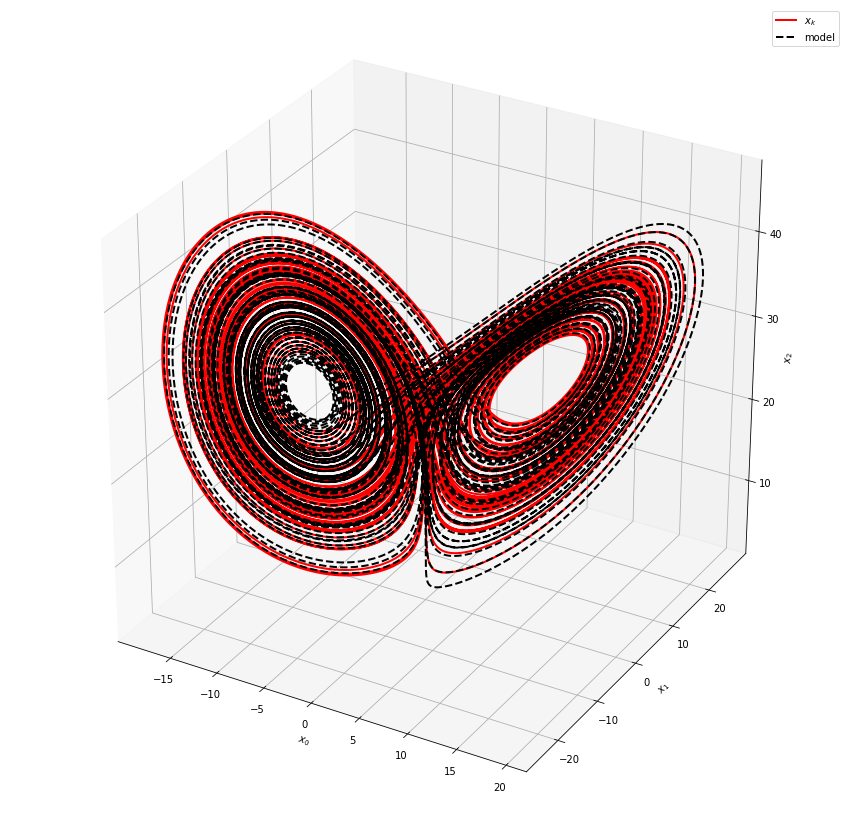

In [ ]:
# adding noise on a scale of 1e-3
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-3, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.995 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -0.002 1 + -2.667 x2 + 1.000 x0 x1


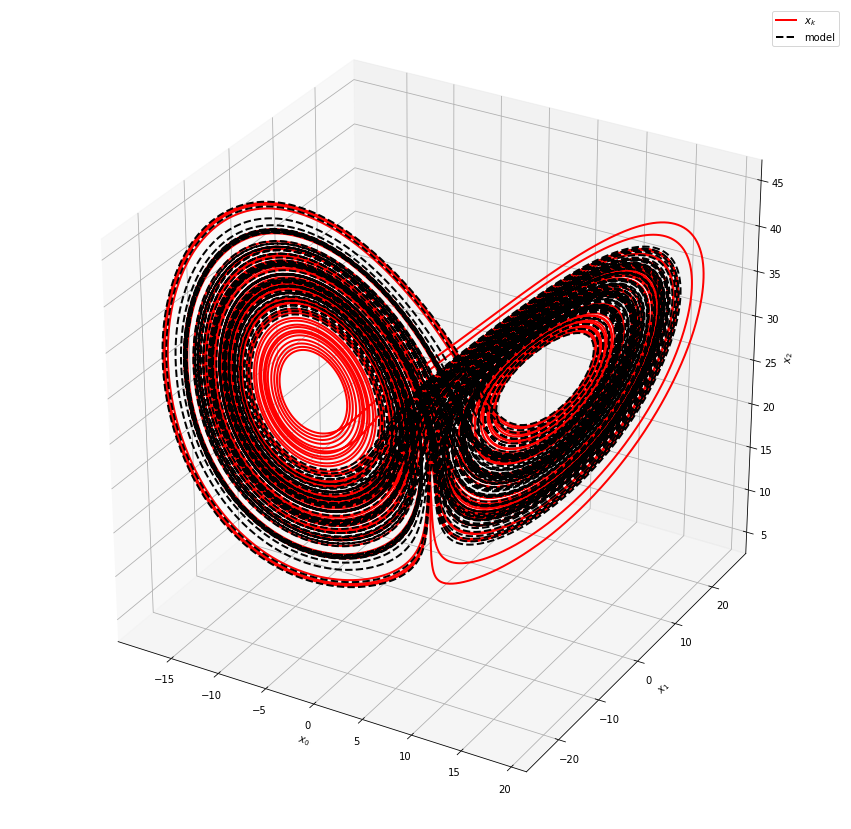

In [ ]:
# adding noise on a scale of 1e-2
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-2, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = 0.013 1 + -9.807 x0 + 9.889 x1 + -0.005 x0 x2 + 0.003 x1 x2
(x1)' = -0.005 1 + 27.900 x0 + -0.942 x1 + -0.997 x0 x2 + -0.002 x1 x2
(x2)' = -0.081 1 + -2.662 x2 + 0.998 x0 x1 + 0.001 x1^2


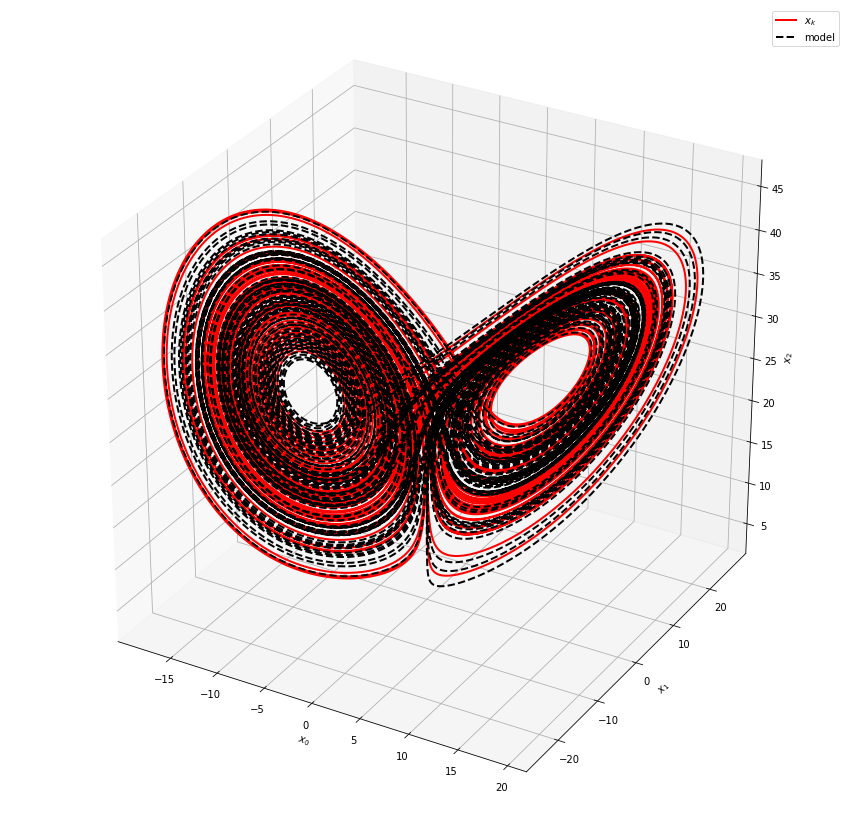

In [ ]:
# adding noise on a scale of 1e-1
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-1, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = 9.853 1 + 1.329 x0 + 3.374 x1 + -1.215 x2 + -0.232 x0^2 + 0.240 x0 x1 + -0.286 x0 x2 + -0.063 x1^2 + 0.148 x1 x2 + 0.039 x2^2
(x1)' = 12.023 1 + 22.519 x0 + 2.112 x1 + -1.533 x2 + -0.269 x0^2 + 0.243 x0 x1 + -0.842 x0 x2 + -0.053 x1^2 + -0.087 x1 x2 + 0.048 x2^2
(x2)' = 3.698 1 + -0.306 x0 + 0.139 x1 + -3.440 x2 + -0.086 x0^2 + 0.902 x0 x1 + 0.006 x0 x2 + 0.097 x1^2 + -0.001 x1 x2 + 0.029 x2^2


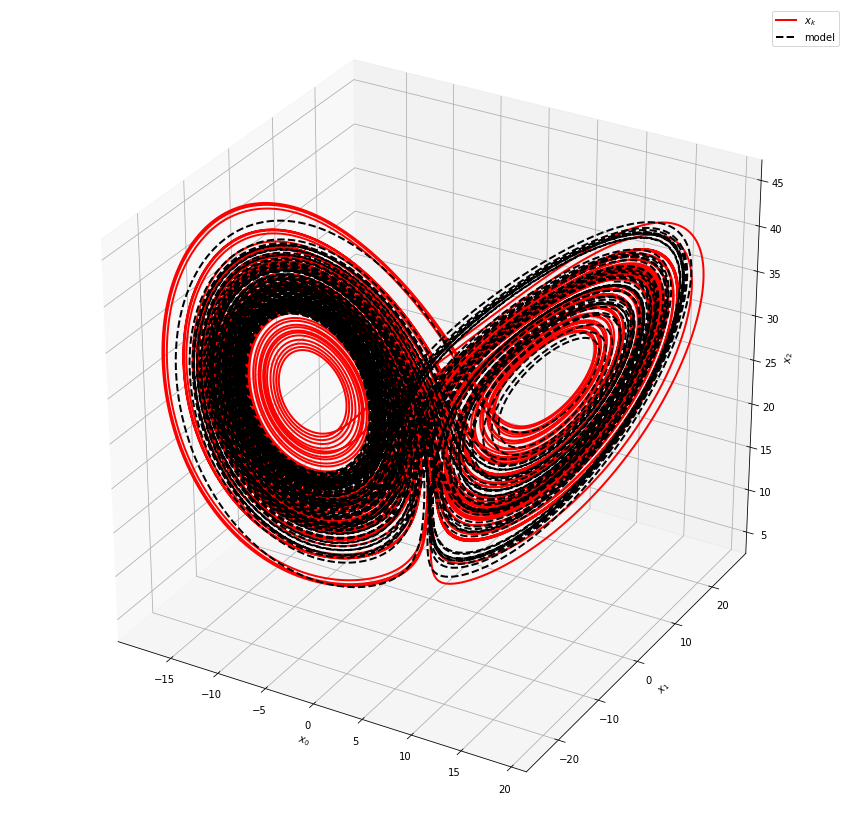

In [ ]:
# adding noise on a scale of 1
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-0, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

### Add comment inference from graphs

Note that the trajectories differ even though there is no error, however, as mentioned above, the attractors are characteristic of the system.

The attractors are predicted correctly even upto an order of $10^{-1}$. However, there is a visible shift in the sttractor when the error is of order $1$.

***


### Trying to find amount of data required for a particular level of noise

Recall that we require the data to find the following equations - 
$$ \begin{aligned} \dot x &= \sigma(y-x)\\ \dot y &= x(\rho - z) - y \\ \dot z &= xy - \beta z, \end{aligned} $$
with $\sigma=10$, $\rho=28$, and $\beta=\tfrac{8}{3}$


Here, we increase the number of training samples and check the minimum number of samples for which the model predicts the above set of equations.

No noise

In [ ]:
# finding the best hyperparameters
model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)

In [ ]:
# considering only 0.4% of the samples without any noise i.e, 400 samples of 100,000
search.fit(x_train[:400])

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.01}
(x0)' = -0.301 1 + -9.964 x0 + 9.992 x1 + 0.017 x2 + -0.001 x0^2 + -0.001 x0 x1 + -0.001 x0 x2 + 0.001 x1 x2
(x1)' = -1.737 1 + 28.045 x0 + -0.979 x1 + 0.136 x2 + 0.001 x0^2 + -0.003 x0 x1 + -1.000 x0 x2 + -0.003 x1^2 + 0.001 x1 x2 + -0.003 x2^2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [ ]:
# considering only 0.425% of the samples without any noise i.e, 425 samples of 100,000
search.fit(x_train[:425])

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.1}
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.999 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


Noise of scale $10^{-4}$


In [ ]:
# adding noise on a scale of 1e-4 
x = x_train[:400]
search.fit(x + np.random.normal(scale=1e-4, size=x.shape), t=dt, quiet=True)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.1}
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = -2.515 1 + 26.247 x0 + -0.190 x1 + 0.625 x2 + 0.072 x0^2 + -0.940 x0 x2 + -0.017 x1^2 + -0.030 x1 x2 + -0.026 x2^2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [ ]:
# adding noise on a scale of 1e-4 
x = x_train[:425]
search.fit(x + np.random.normal(scale=1e-4, size=x.shape), t=dt, quiet=True)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.1}
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.997 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


Noise of scale $10^{-3}$

In [ ]:
### adding noise on a scale of 1e-3
x = x_train[:400]
search.fit(x + np.random.normal(scale=1e-3, size=x.shape), t=dt, quiet=True)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.1}
(x0)' = -55.857 1 + -5.211 x0 + 9.069 x1 + 3.584 x2 + -0.099 x0^2 + -0.194 x0 x1 + -0.091 x0 x2 + -0.016 x1^2 + 0.106 x1 x2 + -0.059 x2^2
(x1)' = 30.189 1 + 26.622 x0 + -1.220 x1 + -2.271 x2 + -0.002 x0^2 + -0.960 x0 x2 + 0.069 x1^2 + -0.025 x1 x2 + 0.043 x2^2
(x2)' = -2.666 x2 + 1.000 x0 x1


In [ ]:
# adding noise on a scale of 1e-3
x = x_train[:450]
search.fit(x + np.random.normal(scale=1e-3, size=x.shape), t=dt, quiet=True)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.1}
(x0)' = -9.998 x0 + 9.998 x1
(x1)' = 27.993 x0 + -1.001 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


Noise of scale $10^{-2}$

In [ ]:
### adding noise on a scale of 1e-2
x = x_train[:2000]
search.fit(x + np.random.normal(scale=1e-2, size=x.shape), t=dt, quiet=True)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.01}
(x0)' = -0.169 1 + -9.246 x0 + 9.646 x1 + 0.036 x0^2 + -0.024 x0 x1 + -0.031 x0 x2 + 0.014 x1 x2
(x1)' = 28.007 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = 0.083 1 + -0.026 x0 + -2.667 x2 + 1.001 x0 x1


In [ ]:
### adding noise on a scale of 1e-2
x = x_train[:2100]
search.fit(x + np.random.normal(scale=1e-2, size=x.shape), t=dt, quiet=True)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.1}
(x0)' = -10.002 x0 + 10.002 x1
(x1)' = 28.007 x0 + -1.002 x1 + -1.000 x0 x2
(x2)' = -2.668 x2 + 1.000 x0 x1


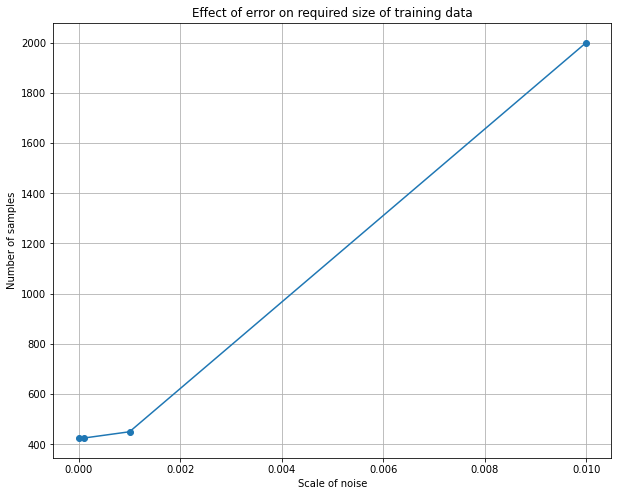

In [ ]:
x = [0, 1e-4, 1e-3, 1e-2]
y = [425, 425, 450, 2000]

fig = plt.figure(figsize=(10, 8))
plt.plot(x,y,marker='o')
plt.xlabel("Scale of noise")
plt.ylabel("Number of samples")
plt.title('Effect of error on required size of training data')
plt.grid(True)
fig.show() 

Thus we can see that the minimum number of samples required for training the model increases with the error.